In [1]:
import os
import pandas as pd
import seaborn as sns

In [2]:
p_base = '/Users/tstoeger/Projects/course_multi_omics' 

# Load data

In [3]:
def load_dataset(dataset):
    """
    Loads a dataset obtained from Harmonizome
    
    Input:
    dataset: name of dataset as used by Harmonizome
    """
    
    p = os.path.join(
        p_base,
        dataset,
        'gene_similarity_matrix_cosine.txt.gz'
    )
    
    # The data by Harmonizome contains additional columns
    # and rows that are not needed. Below loading routine
    # avoids loading them; Also see lecture notes on how
    # to organize tables, which would avoid below
    # complexity :)
    teaser = pd.read_csv(p, sep='\t', nrows=2)
    df = pd.read_csv(
        p, 
        sep='\t', 
        usecols=['#'] + list(teaser.columns[3:]), 
        skiprows=[1, 2], 
        index_col=0)
    return df

In [4]:
# Load some datasets. Note that several are commented out to indicate ways
# how analysis could be extended

datasets_of_interest = {
#     'compartments': 'COMPARTMENTS Experimental Protein Localization Evidence Scores',
#     'drugs': 'DrugBank Drug Targets',
    'gwas_phenotypes': 'GWAS Catalog SNP-Phenotype Associations',
    'pathways': 'KEGG Pathways',
#     'mendelian_disease': 'OMIM Gene-Disease Associations'   
}

In [5]:
datasets = dict()
for short_name, folder_name in datasets_of_interest.items():
    datasets[short_name] = load_dataset(folder_name)

# Example: first look at pathways and GWAS phenotypes

In [6]:
# Find genes 
shared_genes = sorted(
    list(
        set.intersection(*[set(x.columns) for x in datasets.values()])
    )
)

In [7]:
gwas = datasets['gwas_phenotypes'].reindex(index=shared_genes, columns=shared_genes)
pathways = datasets['pathways'].reindex(index=shared_genes, columns=shared_genes)

In [8]:
display(gwas.head(3)) # look at first rows of data
display(pathways.head(3)) # look at first rows of data

,ABAT,ABCA1,ABCA12,ABCA4,ABCA7,ABCA8,ABCB11,ABCB5,ABCB9,ABCC1,...,WNT8A,WNT9B,WWP2,XDH,XYLB,YES1,YWHAG,ZBTB16,ZIC2,ZMAT3
#,,,,,,,,,,,,,,,,,,,,,
ABAT,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABCA1,0.0,1.0,0.0,0.0,0.0,0.353553,0.288675,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABCA12,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.707107,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,ABAT,ABCA1,ABCA12,ABCA4,ABCA7,ABCA8,ABCB11,ABCB5,ABCB9,ABCC1,...,WNT8A,WNT9B,WWP2,XDH,XYLB,YES1,YWHAG,ZBTB16,ZIC2,ZMAT3
#,,,,,,,,,,,,,,,,,,,,,
ABAT,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABCA1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABCA12,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


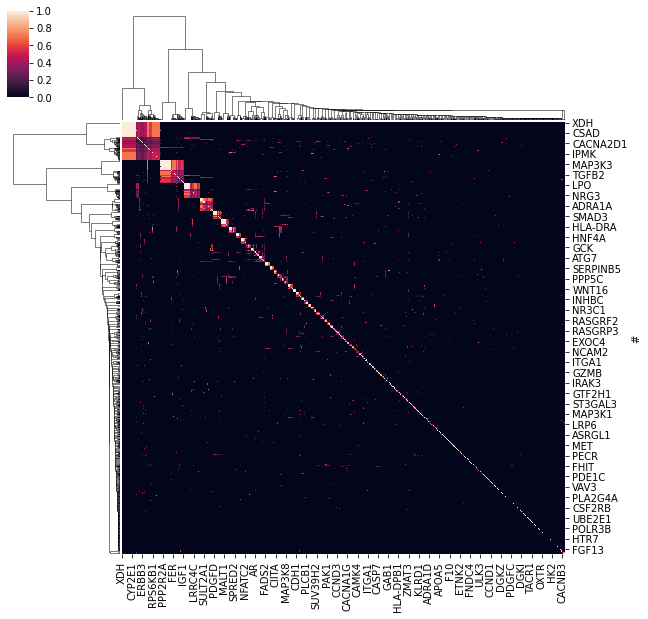

In [9]:
sns.clustermap(gwas, method='ward')

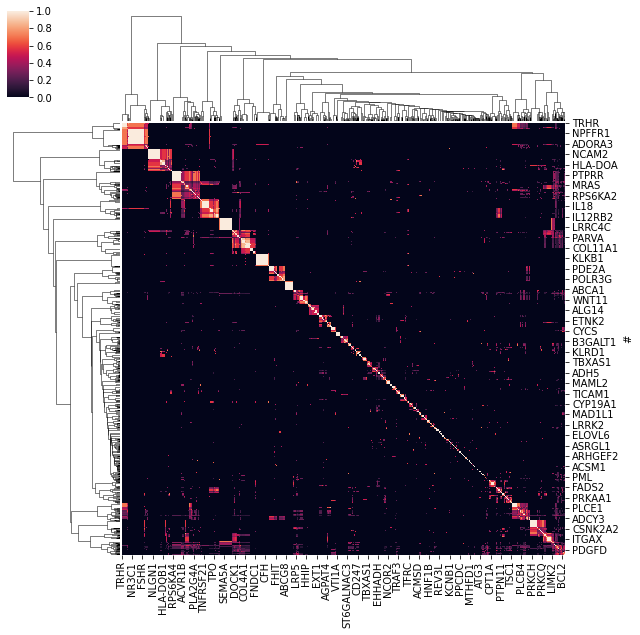

In [10]:
sns.clustermap(pathways, method='ward')

In [11]:
def stack_similarities(df):
    """
    Stacks similarity matrix and ensures that each pair is only
    listed once
    """
    df = df.stack().to_frame(
        'similarity').rename_axis(['cis', 'trans']).reset_index()

    # ensure that each pair is listed only once and that
    # similarities of gene to itself are not shown
    
    df = df[      
        df['cis'] < df['trans']
    ]
    
    return df
    

In [12]:
similarities_in_pathways = stack_similarities(pathways)

In [13]:
similarities_in_pathways.head(10) # see how data looks like

,cis,trans,similarity
1,ABAT,ABCA1,0.0
2,ABAT,ABCA12,0.0
3,ABAT,ABCA4,0.0
4,ABAT,ABCA7,0.0
5,ABAT,ABCA8,0.0
6,ABAT,ABCB11,0.0
7,ABAT,ABCB5,0.0
8,ABAT,ABCB9,0.0
9,ABAT,ABCC1,0.0
10,ABAT,ABCC12,0.0


In [14]:
similarities_in_gwas = stack_similarities(gwas)

In [15]:
# combine both tables based on the gene pairs
together = pd.merge(
    similarities_in_pathways,
    similarities_in_gwas,
    on=['cis', 'trans'],
    suffixes=('_pathways', '_gwas')

)

In [16]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'similarity_gwas')

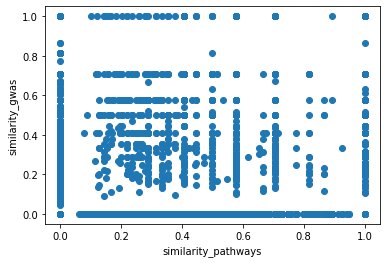

In [17]:
plt.scatter(together['similarity_pathways'], together['similarity_gwas'])
plt.xlabel('similarity_pathways')
plt.ylabel('similarity_gwas')

# To do: Your own exploration

Some first ideas: see if increasing similarties of GWAS increases similarities of pathways; test if restricted to some genes; do a joined clustermap (do GWAS and pathways cluster together?); add different datasets; ... MODIFY ACCORDING TO OWN IDEAS